In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk.history", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0    aeb10ab4-7e56-4681-9504-08d8d2d9b638
dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("1aec")]

Series([], dtype: object)

In [5]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['aeb10ab4-7e56-4681-9504-08d8d2d9b638'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
df["o_ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
df["o_ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed,f_mag,o_ct_v.x,o_ct_v.y
0,0,aeb10ab4-7e56-4681-9504-08d8d2d9b638,42.433333,"[27508.36249723718, 17234.63948507875]",-6.007544,"[-855.3667468257953, -43.68059256713582]",0.128773,"[4993.493252878923, 255.00026167176955]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-43.413822,96.225077,27.216439,856.481328,NaN,10422.055551,851.250530,5000.000000,NaN,NaN
1,1,aeb10ab4-7e56-4681-9504-08d8d2d9b638,42.450000,"[27494.106384790084, 17233.911475202633]",-6.005397,"[-855.3251343820214, -43.67846756495522]",0.112106,"[4993.493252878919, 255.00026167186655]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-43.531727,96.166443,27.422896,856.439662,NaN,10407.780862,853.562397,5000.000000,NaN,NaN
2,2,aeb10ab4-7e56-4681-9504-08d8d2d9b638,42.466667,"[27479.850965883717, 17233.183500743216]",-6.003529,"[-855.2835219382474, -43.67634256277462]",0.095440,"[4993.493252878846, 255.0002616732792]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-43.650253,96.115037,27.602529,856.397995,NaN,10393.506868,855.886438,5000.000000,NaN,NaN
3,3,aeb10ab4-7e56-4681-9504-08d8d2d9b638,42.483333,"[27465.59624051808, 17232.455561700503]",-6.001938,"[-855.2419094944735, -43.67421756059401]",0.078773,"[-4993.493252878964, -255.0002616709628]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-43.769403,96.071010,27.755380,856.356328,NaN,10379.233568,858.222712,5000.000000,NaN,NaN
4,4,aeb10ab4-7e56-4681-9504-08d8d2d9b638,42.500000,"[27451.34220869317, 17231.72765807449]",-6.000625,"[-855.2835219382474, -43.6763425627746]",0.095440,"[4993.493252878904, 255.00026167213468]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-43.510774,96.034487,27.881486,856.397995,NaN,10364.960962,853.151549,5000.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,3595,aeb10ab4-7e56-4681-9504-08d8d2d9b638,102.350000,"[18068.238555755404, 17022.41045433916]",-7.474495,"[5.40630292493165, 6.43212212748258]",-0.347814,"[-3227.2112711155946, -3819.045353433822]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,0.000000,37.044356,-92.885498,8.402399,17868.864724,920.258612,0.000000,5000.000000,-756.390415,646.707225
3596,3596,aeb10ab4-7e56-4681-9504-08d8d2d9b638,102.366667,"[18068.328660804153, 17022.517656374617]",-7.480292,"[5.379409497672354, 6.400296749537298]",-0.364481,"[3224.4279624773285, 3821.395597788104]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,0.000000,36.505288,-93.098679,8.360732,17852.307104,920.390924,0.000000,5000.000000,-756.358746,646.680148
3597,3597,aeb10ab4-7e56-4681-9504-08d8d2d9b638,102.383333,"[18068.418317629115, 17022.62432798711]",-7.486367,"[5.406279730692998, 6.432141712852199]",-0.347814,"[-3228.0474122862183, -3818.338631398772]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,0.000000,35.939073,-93.318717,8.402399,17835.748802,920.522582,0.000000,5000.000000,-756.390415,646.707225
3598,3598,aeb10ab4-7e56-4681-9504-08d8d2d9b638,102.400000,"[18068.508422291292, 17022.73153034899]",-7.492164,"[5.379379335590613, 6.400322224257209]",-0.364481,"[3224.673286258156, 3821.1885843141818]",900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,0.000000,35.397513,-93.525484,8.360732,17819.191284,920.654899,0.000000,5000.000000,-756.358746,646.680148


# Basic Ship Vitals

## Position and Heading

In [10]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=102.41666666666214, continuous_update=False, description='max_time', m…

<function __main__.plot_location_chart(max_time)>

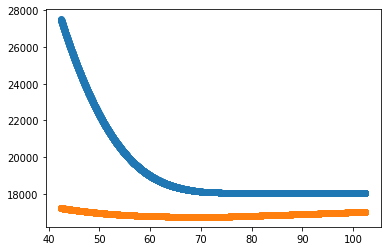

In [11]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

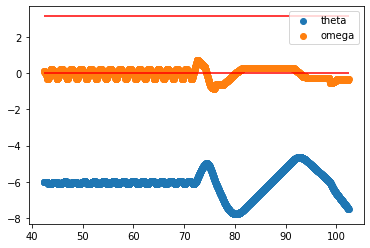

In [12]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()

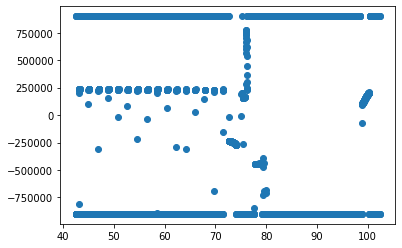

In [13]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

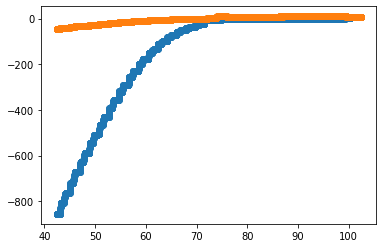

In [14]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

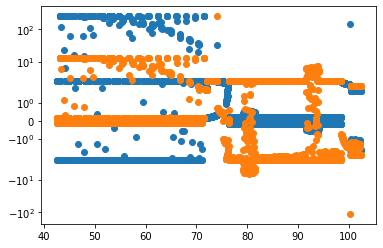

In [15]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

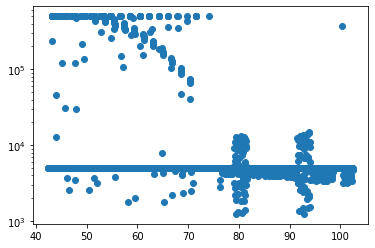

In [16]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")

# Behavior Monitoring

In [17]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [18]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o_t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts                           o_t_dist  \
                          count        min         max         min   
o.t_loc.x    o.t_loc.y                                               
17099.869683 16703.114107  1970  42.433333   75.250000  977.698465   
17218.250190 16601.899803     1  75.266667   75.266667  873.535755   
17278.005241 16550.809754  1629  75.283333  102.416667  827.159655   

                                         
                                    max  
o.t_loc.x    o.t_loc.y                   
17099.869683 16703.114107  10422.055551  
17218.250190 16601.899803    873.535755  
17278.005241 16550.809754    920.786561

(827.1596546534474, 912.9083657847971)

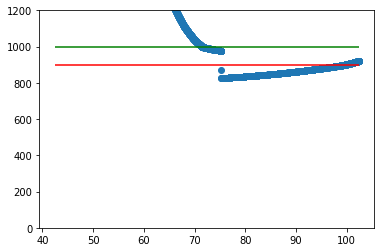

In [28]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
sample = df
plt.scatter(sample["ts"], sample["o_t_dist"])
plt.hlines(1000, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(900, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0,1200)
sample["o_t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o_t_dist"].min()

(0.0, 936.2149280750269)

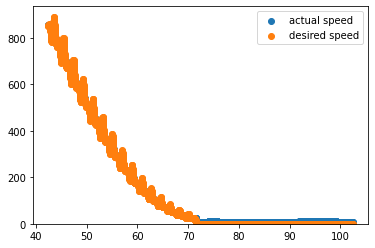

In [20]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)

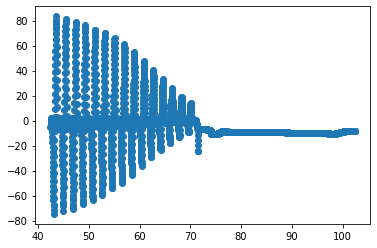

In [21]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

## Collision Avoidance

In [22]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o_ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

ts                         \
                                     count        min         max   
o.ct                                                                
26b4b190-e776-4966-aa9e-c42eb320f7d2  1781  71.566667  102.416667   
353ea317-e8e7-4741-85b0-cb9a959af4ca    71  74.116667   75.283333   

                                         o_ct_dist                
                                               min           max  
o.ct                                                              
26b4b190-e776-4966-aa9e-c42eb320f7d2  17802.634471  48419.640436  
353ea317-e8e7-4741-85b0-cb9a959af4ca    827.159655    981.612687

827.1596546534474

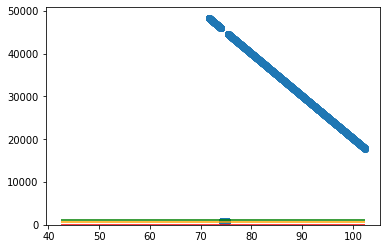

In [23]:
sample = df
plt.scatter(sample["ts"], sample["o_ct_dist"])
plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0)
df["o_ct_dist"].min()

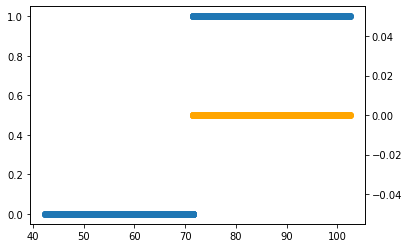

In [24]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

# History Visualization

## Position and Velocity

In [25]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), show_tloc=True):
    #fig, ax = plt.subplots()
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]#.iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o_ct_v.x"], sample["o_ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1000, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 900, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=102.41666666666214, max_time=102.41666666666214, show_tloc=True)>

## Position and Heading

In [26]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=59.983333…

<function __main__.plot_collision_chart(hist_length=102.41666666666214, max_time=102.41666666666214)>

# 